##Data Augmentation

In most DL applications Data is one of the major bottlenecks it is not always easy to collect and lable data. We are always looking for smart ways to reduce the cost of data generation.

One way to do this data augmentaion, where we use the available data to produce more data samples.

In this example we will generate new samples of MNIST dataset using torchvision.transforms.



In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import imageio as Image
from skimage import transform

%matplotlib inline

/home/salman/anaconda3/envs/pyt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/salman/anaconda3/envs/pyt/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/salman/anaconda3/envs/pyt/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
import PIL


# MNIST
def mnist(batch_sz):
    num_classes = 10
    # transform_train = transforms.Compose([
    #                     transforms.RandomCrop(28, padding=4),
    #                     transforms.ToTensor(),
    #                 ])

    transform_train = transforms.Compose([ transforms.ColorJitter(brightness=(0.75, 1.25), ),transforms.RandomAffine(100), transforms.ToTensor()])




    transform_test = transforms.Compose([
                        transforms.ToTensor(),
                    ])

    # Training dataset
    train_data = MNIST(root='./datasets', train=True, download=True, transform=transform_train)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_sz, shuffle=True,pin_memory=True)

    # Test dataset
    test_data = MNIST(root='./datasets', train=False, download=True, transform=transform_test)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_sz, shuffle=False, pin_memory=True)

    return train_loader, test_loader, num_classes


In [ ]:
train_loader, test_loader,_=mnist(10)

In [ ]:
!mkdir 'images'

mkdir: cannot create directory ‘images’: File exists


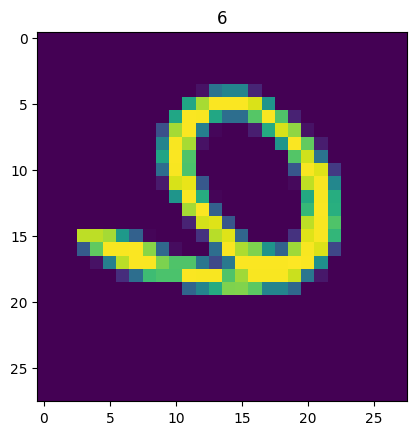

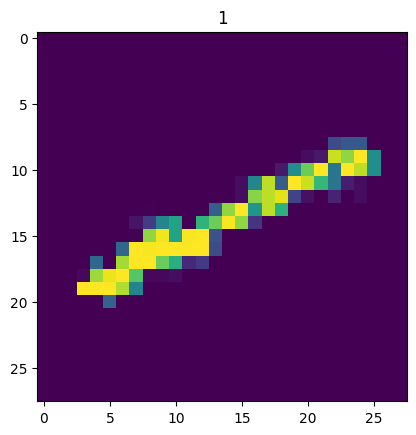

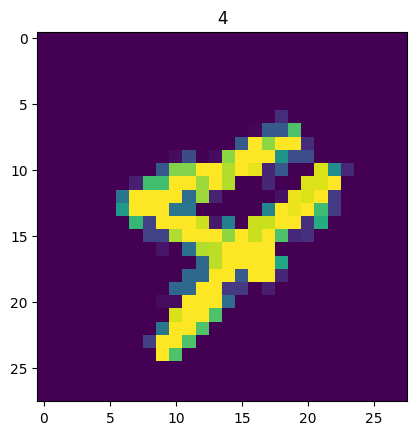

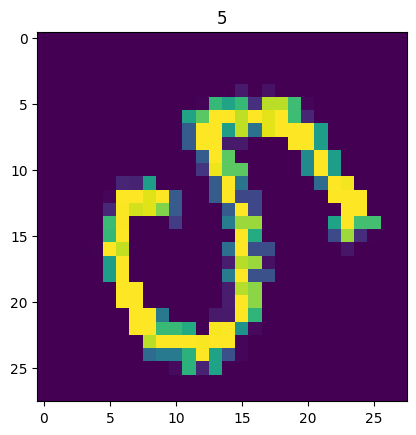

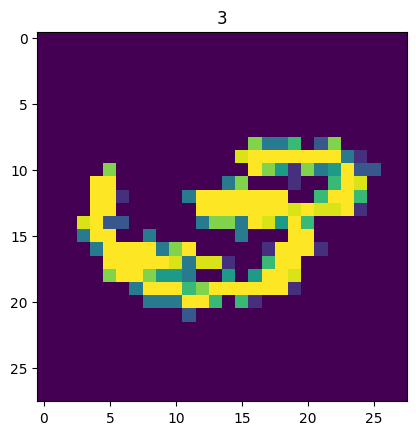

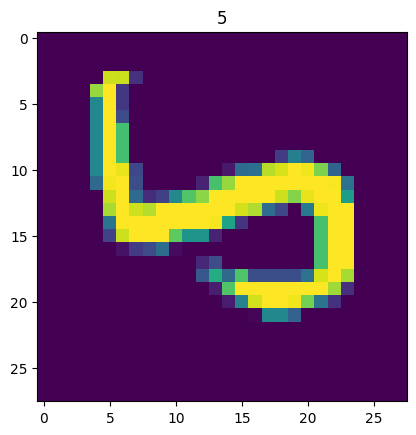

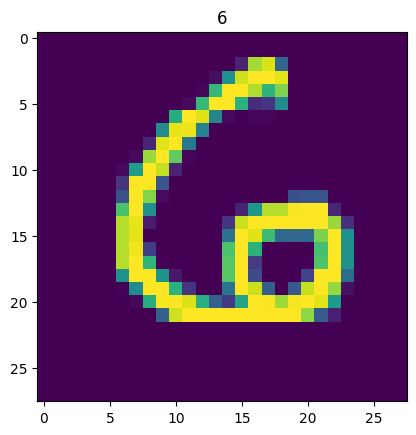

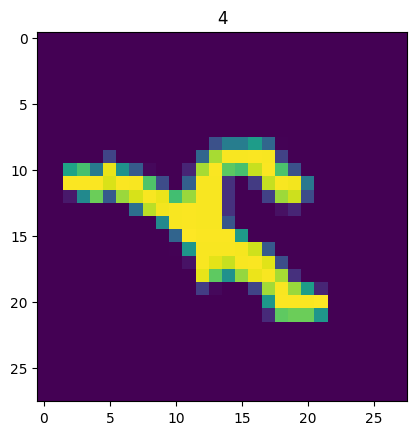

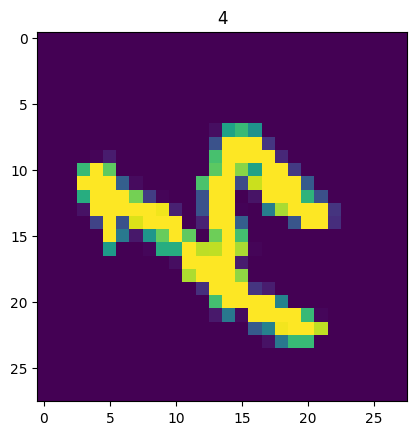

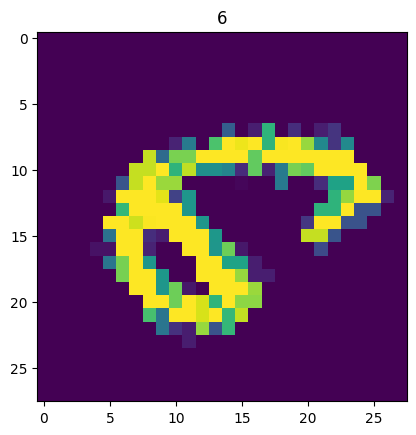

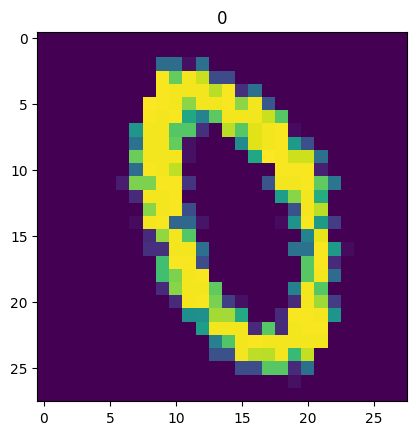

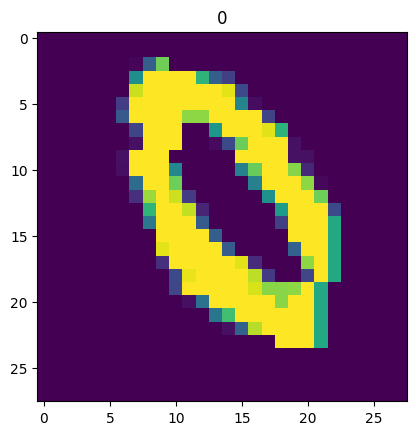

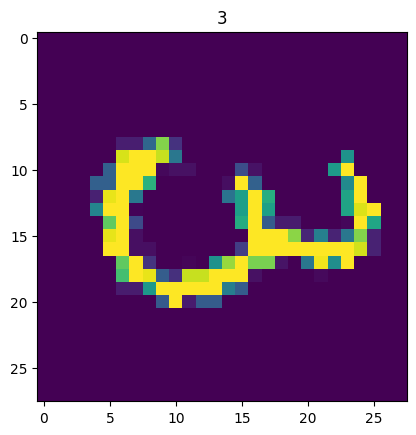

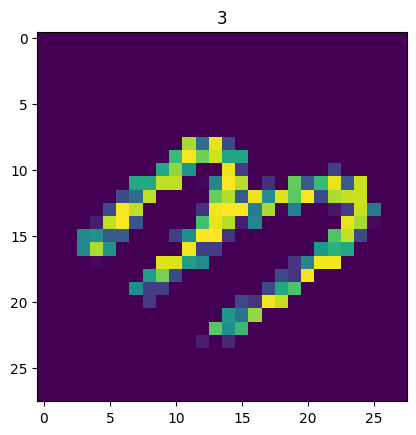

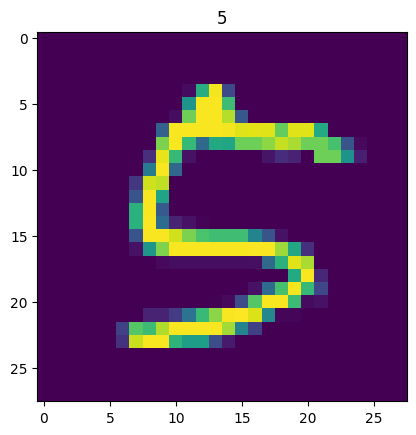

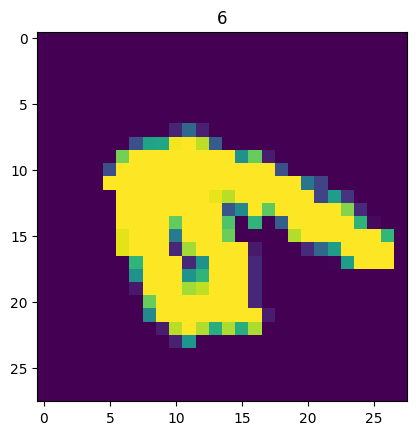

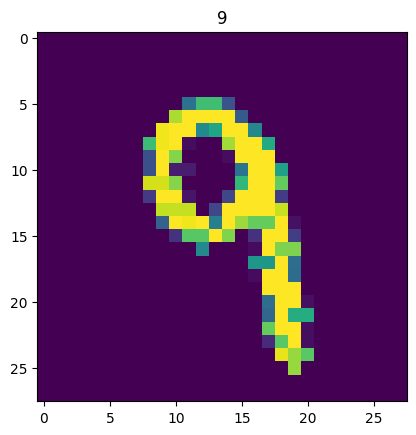

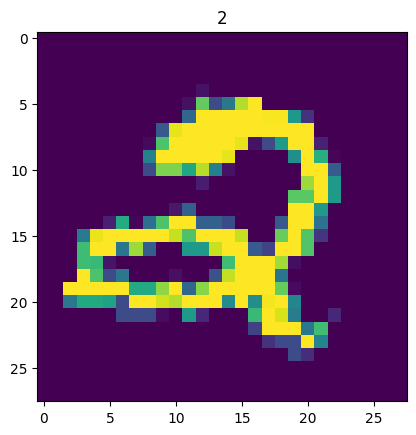

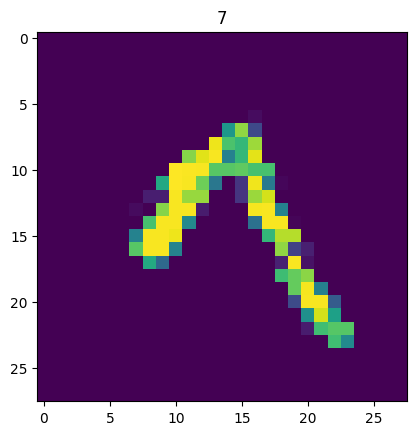

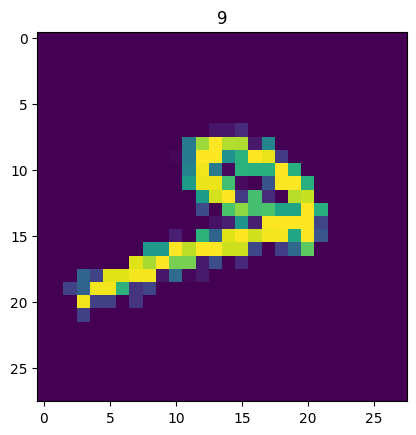

In [ ]:


im_name=[]
labels=[]
ind=0
for i,batch in enumerate(train_loader):
  if i>1:
      break
  for j in range(batch[0].shape[0]):

    im=batch[0][j,:,:,:]
    save_image(im,f"./images/{ind}.jpg",normalize=True)
    im_name.append(f"{ind}.jpg")
    labels.append(batch[1][j].item())
    ind+=1
    im=torch.squeeze(im)
    plt.figure()
    plt.imshow(im)
    plt.title(f"{batch[1][j].item()}")

In [ ]:
batch[0].shape

torch.Size([10, 1, 28, 28])

In [ ]:
import pandas as pd
df=pd.DataFrame(zip(im_name,labels),columns=['Name','label'])

df.to_csv('im_list.csv')

<ipython-input-8-10b80ce00b75>:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread("images/"+df["Name"][i])


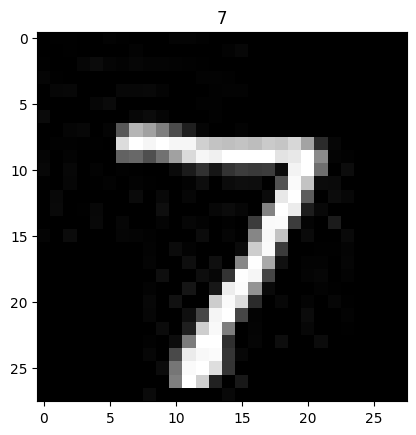

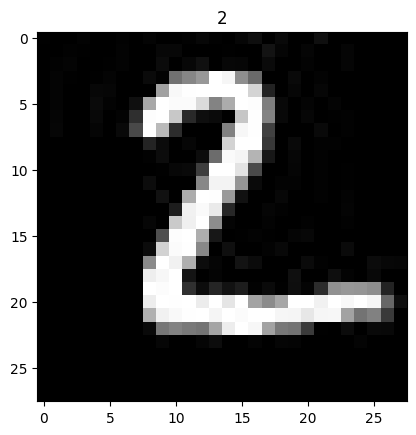

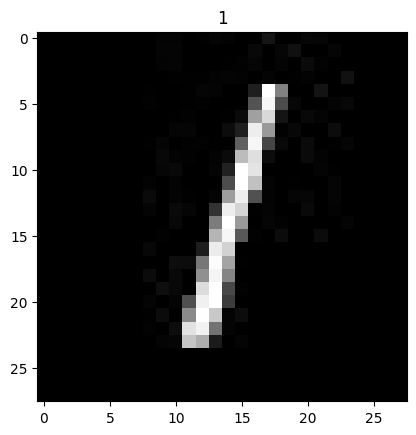

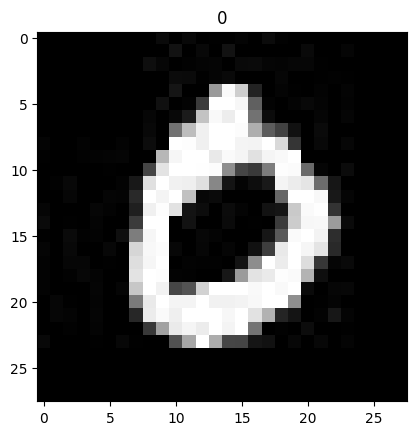

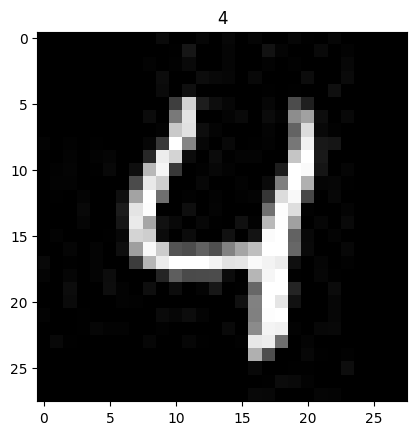

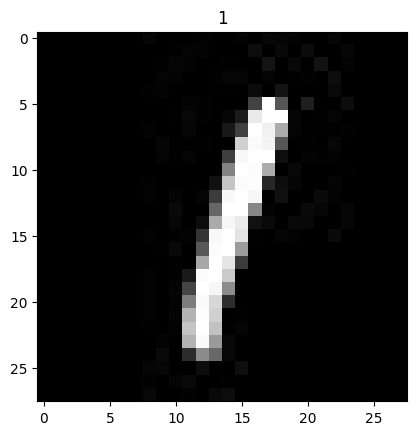

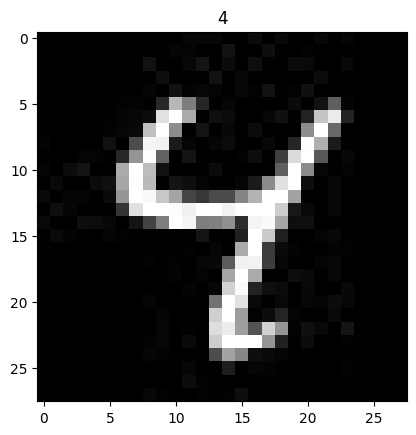

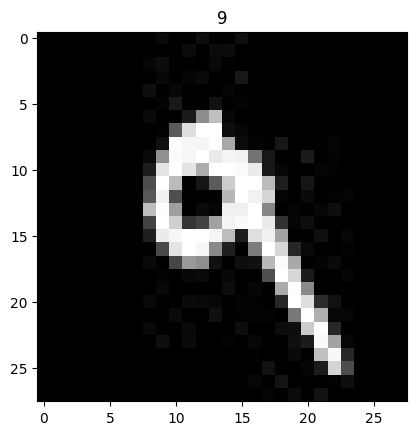

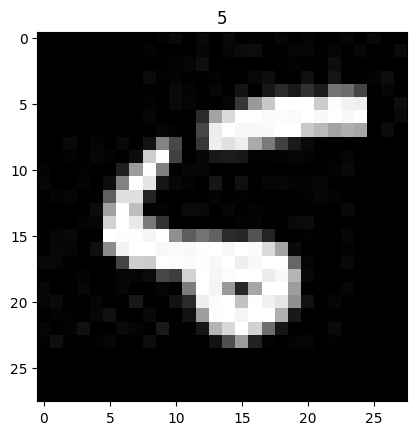

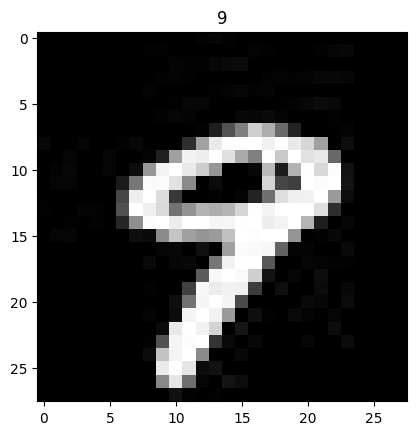

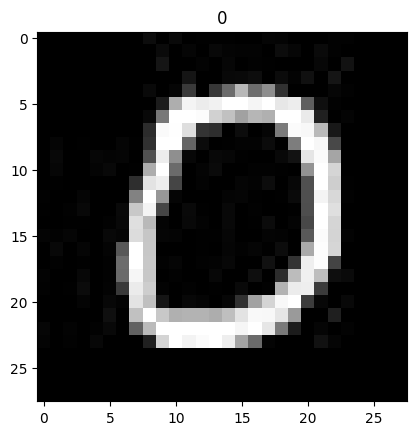

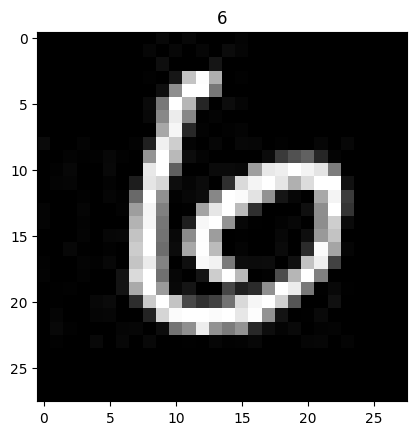

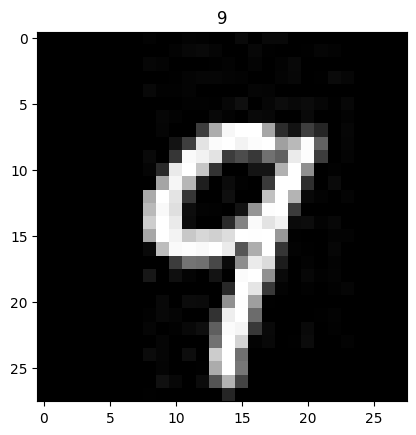

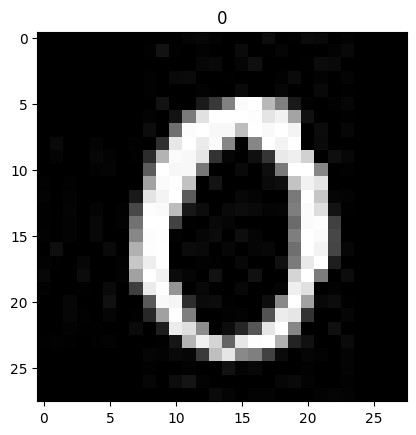

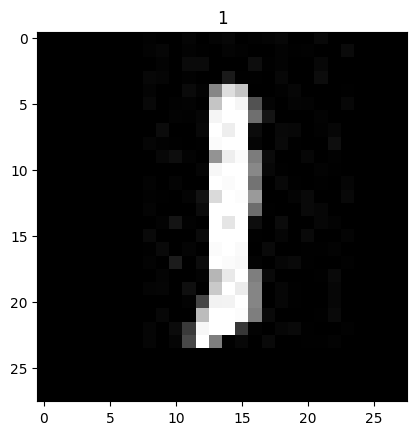

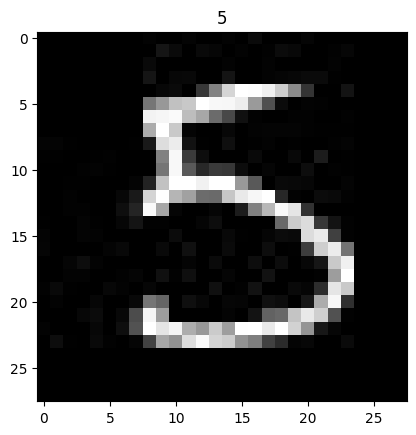

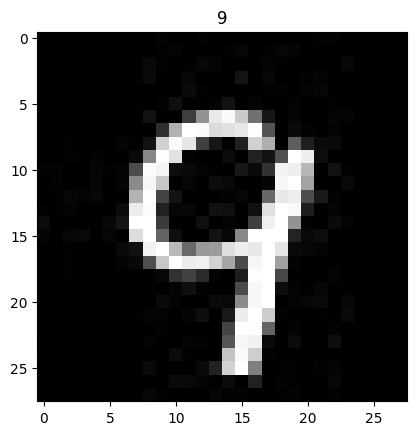

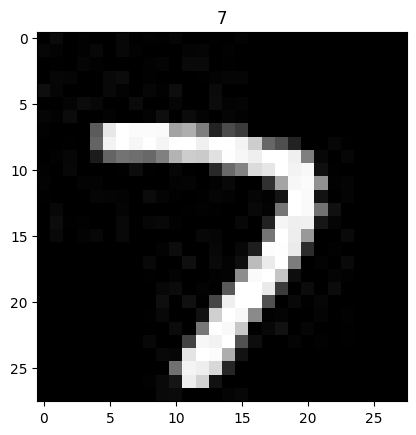

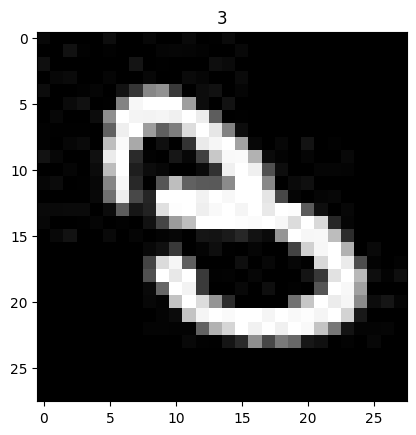

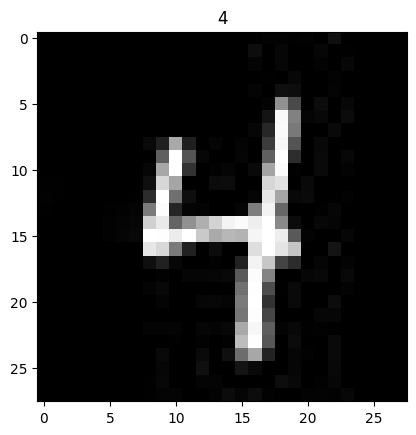

In [ ]:
for i in range(20):
  plt.figure()
  im = Image.imread("images/"+df["Name"][i])
  plt.imshow(im)
  plt.title(df["label"][i])

In [ ]:
# im --->(3, 28,28)
#t --->[shift_down, shift_up, shift_right, shift_left]

def translate(im, t):
  nchannels, nrows, ncols = im.shape
  for idx, val in enumerate(t):

    if val>0 and idx ==0:
      pad = torch.zeros((nchannels,val, ncols ))
      im = torch.concat((pad, im), 1)
      im = im[:,:nrows, :ncols]

    if val>0 and idx ==1:
      pad = torch.zeros((nchannels,val, ncols ))
      im = torch.concat((im, pad), 1)
      im = im[:,val:, :ncols]

    if val>0 and idx ==2:
      pad = torch.zeros((nchannels,nrows, val ))
      im = torch.concat((pad, im), 2)
      im = im[:,:nrows, :ncols]

    if val>0 and idx ==3:
      pad = torch.zeros((nchannels,nrows, val ))
      im = torch.concat((im, pad), 2)
      im = im[:,:nrows, val:]



  return im







In [ ]:
class Translate:
  def __init__(self, t):
    self.t = torch.randint(0, t, (1,4)).squeeze().numpy().tolist()
    print(self.t)
  # im --->(3, 28,28)
#t --->[shift_down, shift_up, shift_right, shift_left]

  def __call__(self, im):
    nchannels, nrows, ncols = im.shape
    for idx, val in enumerate(self.t):

      if val>0 and idx ==0:
        pad = torch.zeros((nchannels,val, ncols ))
        im = torch.concat((pad, im), 1)
        im = im[:,:nrows, :ncols]

      if val>0 and idx ==1:
        pad = torch.zeros((nchannels,val, ncols ))
        im = torch.concat((im, pad), 1)
        im = im[:,val:, :ncols]

      if val>0 and idx ==2:
        pad = torch.zeros((nchannels,nrows, val ))
        im = torch.concat((pad, im), 2)
        im = im[:,:nrows, :ncols]

      if val>0 and idx ==3:
        pad = torch.zeros((nchannels,nrows, val ))
        im = torch.concat((im, pad), 2)
        im = im[:,:nrows, val:]



    return im







In [ ]:
from torchvision import transforms

toTensor = transforms.ToTensor()
class MyDataset(Dataset):
  def __init__(self, imFol, csv_file, transforms = None):
    super().__init__()
    self.imFol = imFol
    df = pd.read_csv("im_list.csv")
    self.images = df["Name"].tolist()
    self.labels = df["label"].tolist()
    self.trans = transforms

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    im = Image.imread(self.imFol + self.images[idx])
    label = self.labels[idx]
    #im = translate(im,[0,0,0,10])
    if self.trans:
      im = self.trans(im)
    return (im, label)



[6, 11, 11, 6]


<ipython-input-11-6c7bf4404bd9>:17: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = Image.imread(self.imFol + self.images[idx])


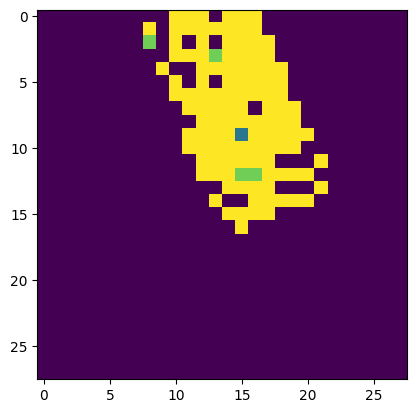

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), Translate(20),transforms.RandomAffine(30), transforms.ColorJitter([100,100])])
dataset = MyDataset("images/", "im_list.csv",transforms = transform)
plt.imshow(dataset[0][0][0,:,:])

In [ ]:
df

,Name,label
0,0.jpg,7
1,1.jpg,2
2,2.jpg,1
3,3.jpg,0
4,4.jpg,4
...,...,...
305,5.jpg,0
306,6.jpg,2
307,7.jpg,7
308,8.jpg,4
